<a href="https://colab.research.google.com/github/CodeofRahul/-YouTube-Study-Notes-Automator/blob/main/02_Yt2Pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. This is working good"

In [ ]:
# @title 🚀 YouTube to PDF (Simplified Folders)
import os
import shutil
import cv2
import yt_dlp
import numpy as np
from fpdf import FPDF
from tqdm.notebook import tqdm
from PIL import Image

# --- User Settings ---
MIN_INTERVAL_SECONDS = 5  # Capture a slide every 5 seconds (if changed)
SENSITIVITY = 15          # Lower = captures more minor changes

# --- Setup Folders ---
PDF_FOLDER = "Final_PDF_Notes"
RESOURCE_FOLDER = "Captured_Resources"

for folder in [PDF_FOLDER, RESOURCE_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)

def clean_name(text):
    return "".join([c for c in text if c.isalnum() or c in (' ', '_')]).strip()

def process_video(url):
    # 1. Download Video
    print(f"\n🌐 Accessing: {url}")
    ydl_opts = {
        'format': 'best[height<=720]',
        'outtmpl': f'{RESOURCE_FOLDER}/temp_video.mp4',
        'overwrites': True,
        'quiet': True
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        video_title = clean_name(info.get('title', 'Study_Notes'))

    # 2. Extract Slides
    video_path = f'{RESOURCE_FOLDER}/temp_video.mp4'
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    last_frame_gray = None
    saved_count = 0

    print(f"📸 Extracting slides from: {video_title}")
    pbar = tqdm(total=total_frames, desc="Progress")

    current_frame = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        should_save = False
        if last_frame_gray is None:
            should_save = True
        else:
            # Compare current frame with the last saved one
            diff = cv2.absdiff(gray, last_frame_gray)
            change_percent = (np.count_nonzero(diff > 25) * 100) / (gray.shape[0] * gray.shape[1])
            if change_percent > SENSITIVITY:
                should_save = True

        if should_save:
            img_path = f"{RESOURCE_FOLDER}/slide_{saved_count:03d}.jpg"
            cv2.imwrite(img_path, frame)
            last_frame_gray = gray
            saved_count += 1

            # Jump forward to avoid "duplicate" shots of the same slide
            current_frame += int(fps * MIN_INTERVAL_SECONDS)
        else:
            current_frame += int(fps) # Check every 1 second if no change

        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        pbar.update(int(fps * MIN_INTERVAL_SECONDS))

    cap.release()
    pbar.close()

    # 3. Generate PDF
    if saved_count > 0:
        print(f"📄 Creating PDF from {saved_count} slides...")
        images = sorted([f for f in os.listdir(RESOURCE_FOLDER) if f.startswith("slide_")])

        # Get dimensions from first image
        with Image.open(f"{RESOURCE_FOLDER}/{images[0]}") as img:
            w, h = img.size

        pdf = FPDF(unit="pt", format=[w, h])
        for img_name in images:
            pdf.add_page()
            pdf.image(f"{RESOURCE_FOLDER}/{img_name}", 0, 0, w, h)

        pdf_filename = f"{PDF_FOLDER}/{video_title}.pdf"
        pdf.output(pdf_filename, "F")
        print(f"✅ SUCCESS: {pdf_filename} created!")
    else:
        print("❌ Failed to detect any slides.")

    # 4. Clean up resources for next video
    for f in os.listdir(RESOURCE_FOLDER):
        os.remove(os.path.join(RESOURCE_FOLDER, f))

# --- Run ---
input_url = input("Enter YouTube Link: ")
if "playlist" in input_url:
    with yt_dlp.YoutubeDL({'extract_flat': True, 'quiet': True}) as ydl:
        playlist_info = ydl.extract_info(input_url, download=False)
        for entry in playlist_info['entries']:
            process_video(entry['url'])
else:
    process_video(input_url)

Enter YouTube Link: https://youtu.be/HVvN4T6AzSk?si=bH5Rw63lue9dY1-v

🌐 Accessing: https://youtu.be/HVvN4T6AzSk?si=bH5Rw63lue9dY1-v


📸 Extracting slides from: भरत एव इसक पडस दश 1  BLOCK STATISTICAL OFFICER  BSO EXAM परपरशन


Progress:   0%|          | 0/235733 [00:00<?, ?it/s]

📄 Creating PDF from 153 slides...
✅ SUCCESS: Final_PDF_Notes/भरत एव इसक पडस दश 1  BLOCK STATISTICAL OFFICER  BSO EXAM परपरशन.pdf created!


# **2. This is Best**

In [6]:
!pip install yt_dlp fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=595b570cb5aee32b2017000705ce245d26c5c0757c9f68298787eb3d48e14dbf
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [7]:
# @title 🚀 YouTube to PDF (Anti-Duplicate & Super Fast)
import os, shutil, cv2, yt_dlp, numpy as np
from fpdf import FPDF
from tqdm.notebook import tqdm
from PIL import Image

# --- Advanced Tuning ---
JUMP_SECONDS = 15     # Check every 15 seconds (Standard for lectures)
SIMILARITY_LIMIT = 0.95 # Higher = stricter. 0.95 means 95% similar images are ignored.
DOWNLOAD_RES = "480"

PDF_FOLDER = "Final_PDF_Notes"
RESOURCE_FOLDER = "Captured_Resources"
for folder in [PDF_FOLDER, RESOURCE_FOLDER]:
    if not os.path.exists(folder): os.makedirs(folder)

def get_similarity(img1, img2):
    """Calculates how similar two slides are (0.0 to 1.0)"""
    # Resize to very small for a 'global' comparison
    img1 = cv2.resize(img1, (128, 128))
    img2 = cv2.resize(img2, (128, 128))
    # Compute Template Matching or Histogram
    res = cv2.matchTemplate(img1, img2, cv2.TM_CCOEFF_NORMED)
    return res[0][0]

def process_video_smart(url):
    print(f"\n🌐 Downloading Video...")
    ydl_opts = {
        'format': f'best[height<={DOWNLOAD_RES}]',
        'outtmpl': f'{RESOURCE_FOLDER}/temp_video.mp4',
        'overwrites': True, 'quiet': True
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        video_title = "".join([c for c in info.get('title', 'Notes') if c.isalnum() or c==' ']).strip()

    cap = cv2.VideoCapture(f'{RESOURCE_FOLDER}/temp_video.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    last_saved_gray = None
    saved_count = 0

    print(f"🎬 Processing: {video_title}")
    pbar = tqdm(total=total_frames)

    curr_frame = 0
    while curr_frame < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        is_different = False
        if last_saved_gray is None:
            is_different = True
        else:
            similarity = get_similarity(gray, last_saved_gray)
            # If similarity is less than 95%, it's a new slide
            if similarity < SIMILARITY_LIMIT:
                is_different = True

        if is_different:
            cv2.imwrite(f"{RESOURCE_FOLDER}/slide_{saved_count:03d}.jpg", frame)
            last_saved_gray = gray
            saved_count += 1

        curr_frame += int(fps * JUMP_SECONDS)
        pbar.update(int(fps * JUMP_SECONDS))

    cap.release()
    pbar.close()

    if saved_count > 0:
        images = sorted([f for f in os.listdir(RESOURCE_FOLDER) if f.startswith("slide_")])
        with Image.open(f"{RESOURCE_FOLDER}/{images[0]}") as img:
            w, h = img.size

        pdf = FPDF(unit="pt", format=[w, h])
        for img_name in images:
            pdf.add_page()
            pdf.image(f"{RESOURCE_FOLDER}/{img_name}", 0, 0, w, h)

        pdf_path = f"{PDF_FOLDER}/{video_title}.pdf"
        pdf.output(pdf_path, "F")
        print(f"✅ FINISHED! Total Pages: {saved_count}")
        print(f"📂 Location: {pdf_path}")

    # Cleanup resources
    for f in os.listdir(RESOURCE_FOLDER): os.remove(os.path.join(RESOURCE_FOLDER, f))

# --- Run ---
input_url = input("Enter YouTube Link: ")
process_video_smart(input_url)

Enter YouTube Link: https://youtu.be/4WFqfPuHHw0?si=7IBght5n_ersWzQG

🌐 Downloading Video...


🎬 Processing: DIGESTIVE SYSTEM पचन ततर


  0%|          | 0/111907 [00:00<?, ?it/s]

✅ FINISHED! Total Pages: 117
📂 Location: Final_PDF_Notes/DIGESTIVE SYSTEM पचन ततर.pdf


# upload pdf and delete unwanted pages (Pdf cleaning)

Preparing tools...


Saving 07 QR Series 7  BLOCK STATISTICAL OFFICER  BSSC CGL4.pdf to 07 QR Series 7  BLOCK STATISTICAL OFFICER  BSSC CGL4.pdf
Generating preview... please wait.


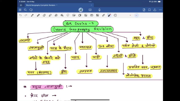

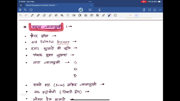

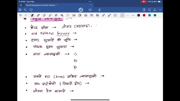

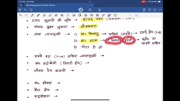

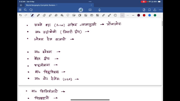

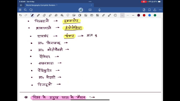

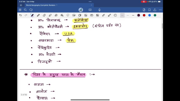

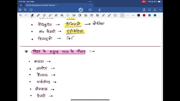

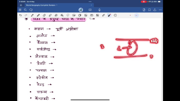

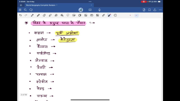

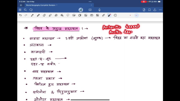

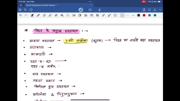

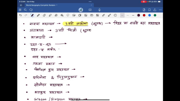

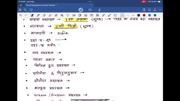

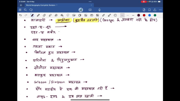

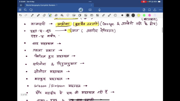

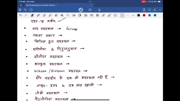

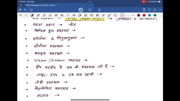

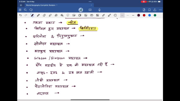

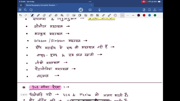

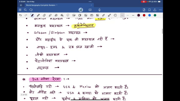

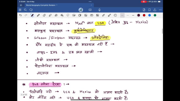

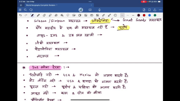

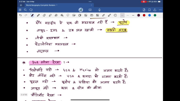

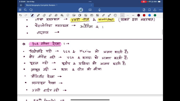

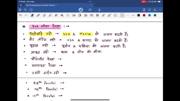

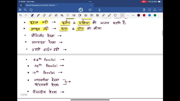

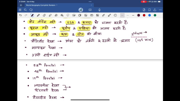

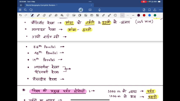

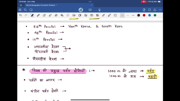

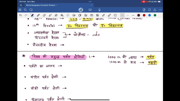

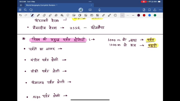

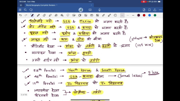

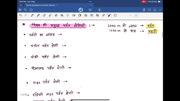

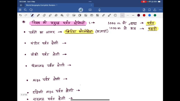

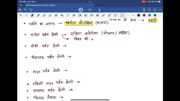

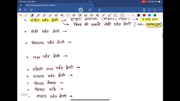

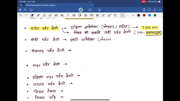

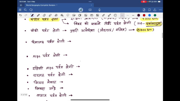

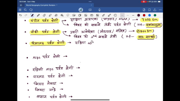

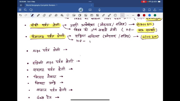

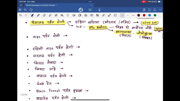

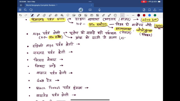

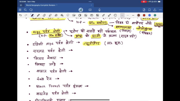

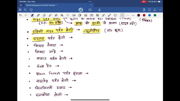

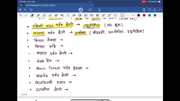

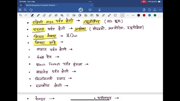

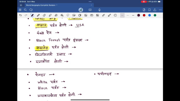

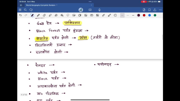

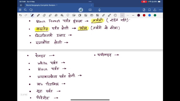

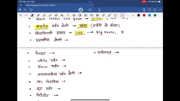

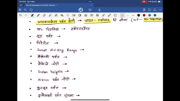

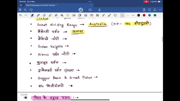

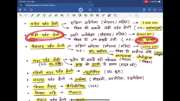

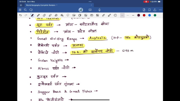

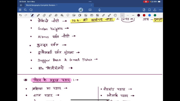

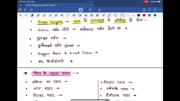

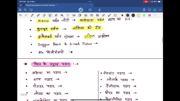

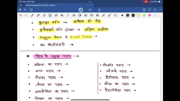

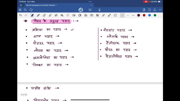

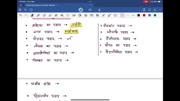

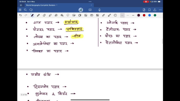

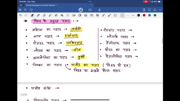

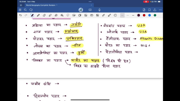

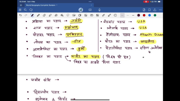

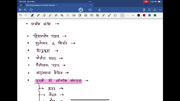

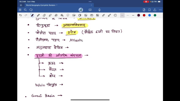

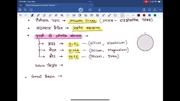

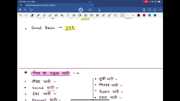

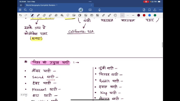

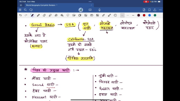

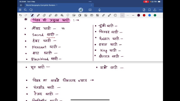

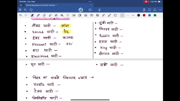

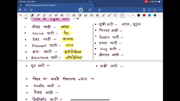

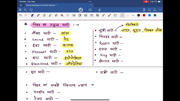

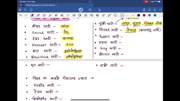

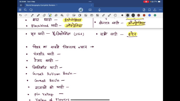

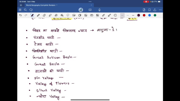

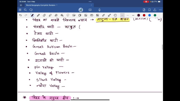

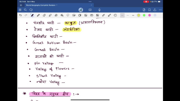

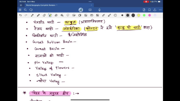

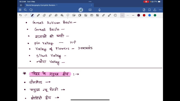

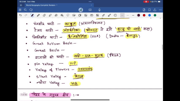

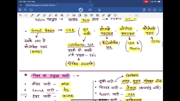

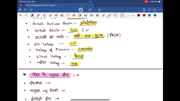

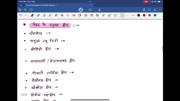

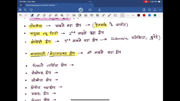

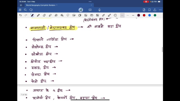

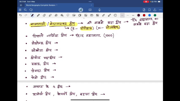

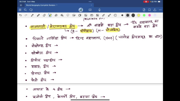

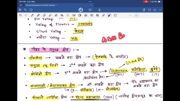

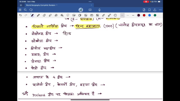

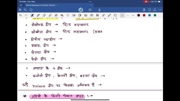

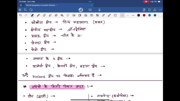

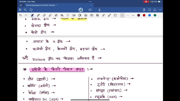

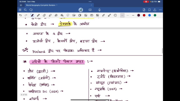

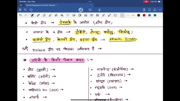

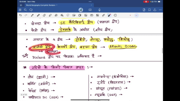

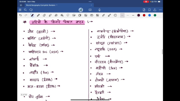

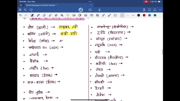

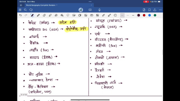

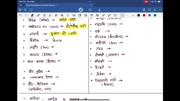

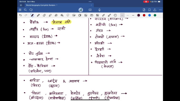

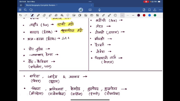

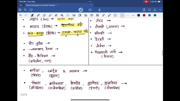

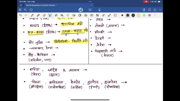

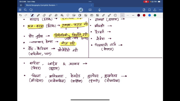

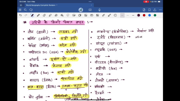

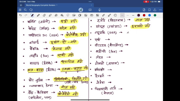

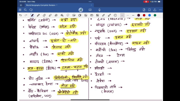

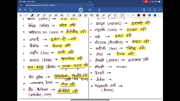

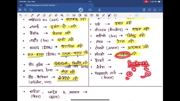

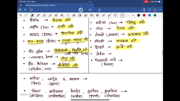

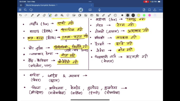

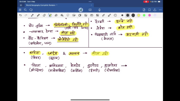

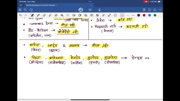

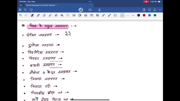

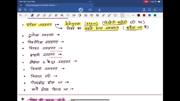

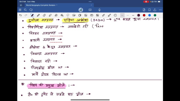

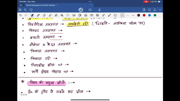

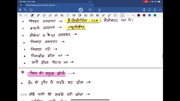

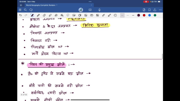

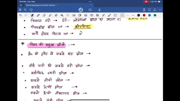

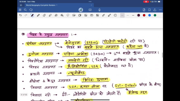

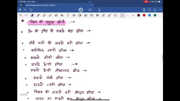

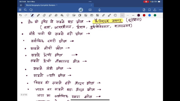

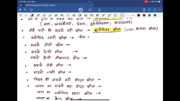

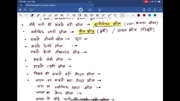

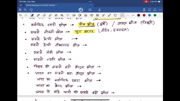

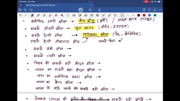

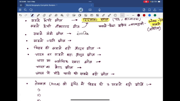

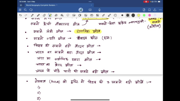

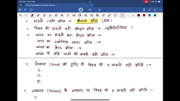

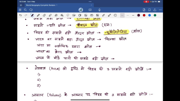

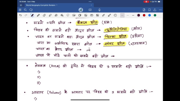

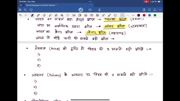

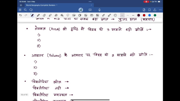

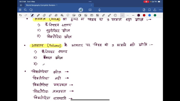

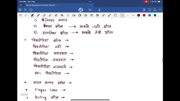

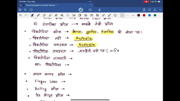

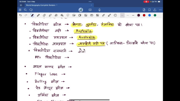

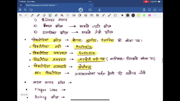

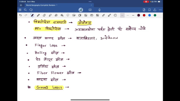

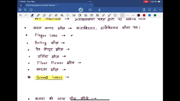

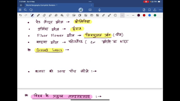

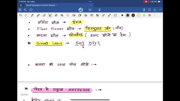

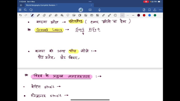

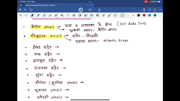

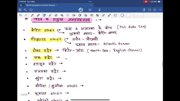

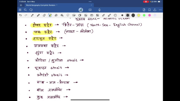

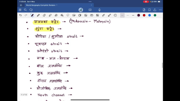

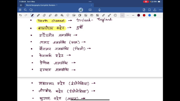

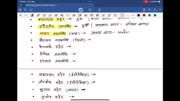

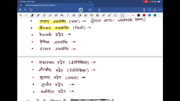

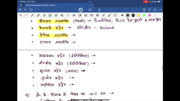

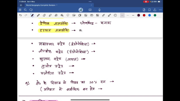

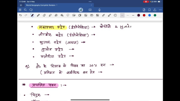

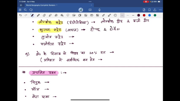

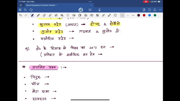

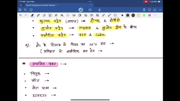

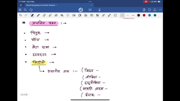

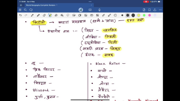

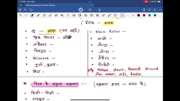

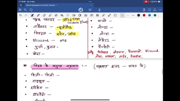

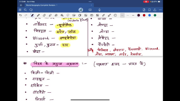

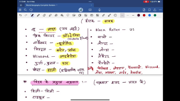

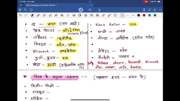

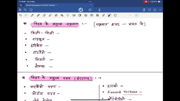

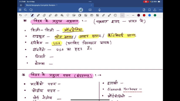

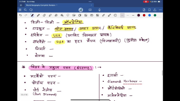

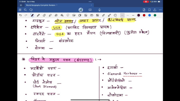

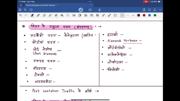

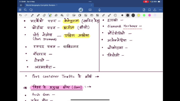

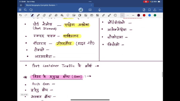

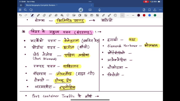

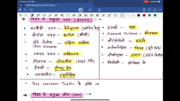

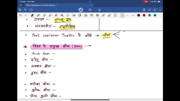

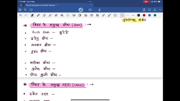

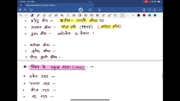

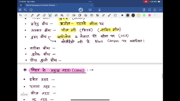

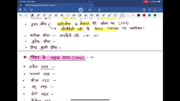

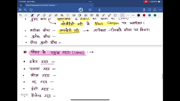

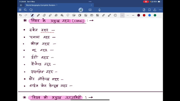

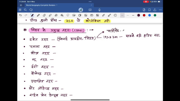

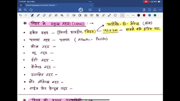

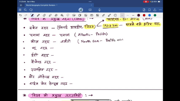

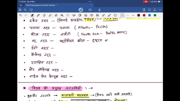

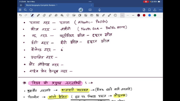

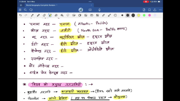

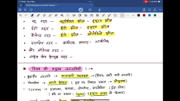

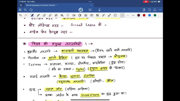

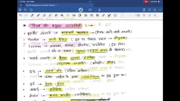

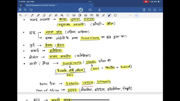

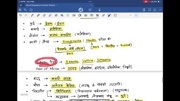

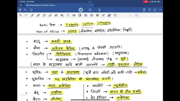

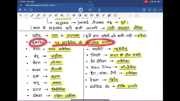

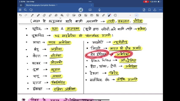

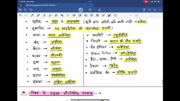

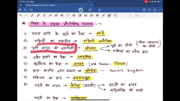

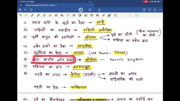

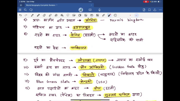

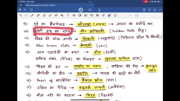

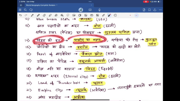

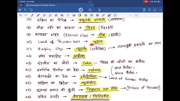

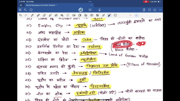

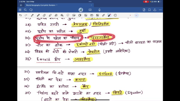

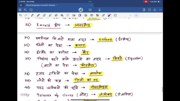

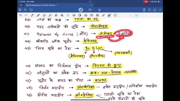

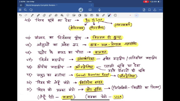

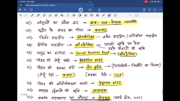

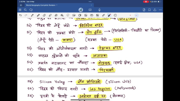

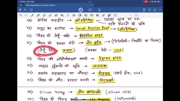

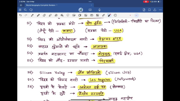

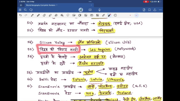

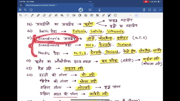

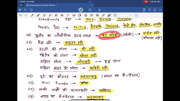

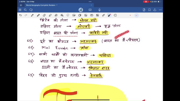

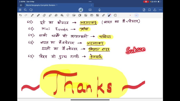


✅ Use Bulk Actions or click individual buttons:


GridBox(children=(VBox(children=(Output(), Button(button_style='success', description='KEEP P1', layout=Layout…

Button(button_style='primary', description='DOWNLOAD CLEANED PDF', layout=Layout(height='50px', margin='20px',…

Output()

In [ ]:
# @title ✂️ PDF Page Manager (With Select/Deselect All)
import os
from google.colab import files
from IPython.display import display, clear_output
import ipywidgets as widgets

# 1. --- Install Dependencies ---
print("Preparing tools...")
!apt-get install -y poppler-utils > /dev/null
!pip install -q pdf2image
from pdf2image import convert_from_path
from PIL import Image

# 2. --- File Upload ---
uploaded = files.upload()
if not uploaded:
    print("No file uploaded.")
else:
    pdf_filename = list(uploaded.keys())[0]

    # 3. --- Convert PDF ---
    print("Generating preview... please wait.")
    preview_pages = convert_from_path(pdf_filename, dpi=40) # Even lower DPI for speed
    page_status = [True] * len(preview_pages)
    button_widgets = []

    # 4. --- Toggle Logic ---
    def update_button(btn, index):
        if page_status[index]:
            btn.description = f"KEEP P{index+1}"
            btn.button_style = 'success'
        else:
            btn.description = f"REMOVE P{index+1}"
            btn.button_style = 'danger'

    def on_toggle_click(b):
        idx = b.index_ref
        page_status[idx] = not page_status[idx]
        update_button(b, idx)

    # 5. --- Bulk Action Buttons ---
    def select_all(b):
        for i in range(len(page_status)):
            page_status[i] = True
            update_button(button_widgets[i], i)

    def deselect_all(b):
        for i in range(len(page_status)):
            page_status[i] = False
            update_button(button_widgets[i], i)

    btn_all = widgets.Button(description="Select All (Green)", button_style='info')
    btn_none = widgets.Button(description="Deselect All (Red)", button_style='warning')
    btn_all.on_click(select_all)
    btn_none.on_click(deselect_all)

    # 6. --- Build Gallery ---
    items = []
    for i, page in enumerate(preview_pages):
        img_out = widgets.Output()
        with img_out:
            display(page.resize((180, int(180 * page.height / page.width))))

        btn = widgets.Button(description=f"KEEP P{i+1}", button_style='success', layout=widgets.Layout(width='180px'))
        btn.index_ref = i
        btn.on_click(on_toggle_click)
        button_widgets.append(btn)

        box = widgets.VBox([img_out, btn], layout=widgets.Layout(border='1px solid #ddd', margin='5px', align_items='center'))
        items.append(box)

    grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(auto-fill, minmax(200px, 1fr))"))

    print("\n✅ Use Bulk Actions or click individual buttons:")
    display(widgets.HBox([btn_all, btn_none]))
    display(grid)

    # 7. --- Final Save ---
    final_btn = widgets.Button(description="DOWNLOAD CLEANED PDF", button_style='primary', layout=widgets.Layout(width='300px', height='50px', margin='20px'))
    status_out = widgets.Output()

    def download_final(b):
        with status_out:
            clear_output()
            print("⏳ Creating high-quality PDF... Please wait.")
            high_res = convert_from_path(pdf_filename, dpi=150)
            final_list = [high_res[i] for i, keep in enumerate(page_status) if keep]

            if not final_list:
                print("❌ No pages selected!")
                return

            out_name = f"Cleaned_{pdf_filename}"
            final_list[0].save(out_name, save_all=True, append_images=final_list[1:])
            print(f"✅ Success! Saved {len(final_list)} pages.")
            files.download(out_name)

    final_btn.on_click(download_final)
    display(final_btn, status_out)

# **Crop, reorder option**

In [ ]:
# @title 🛠️ Ultimate PDF Editor (Crop, Sort, Delete)
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image, ImageDraw
import shutil

# 1. --- Install & Setup ---
print("⚙️ Loading Editor Tools...")
try:
    from pdf2image import convert_from_path
except ImportError:
    !apt-get install -y poppler-utils > /dev/null
    !pip install -q pdf2image
    from pdf2image import convert_from_path
from google.colab import files

# 2. --- Upload PDF ---
print("\n📂 Please upload the PDF you want to edit:")
uploaded = files.upload()

if not uploaded:
    print("❌ No file uploaded. Rerun cell to try again.")
else:
    pdf_filename = list(uploaded.keys())[0]
    print("⏳ Processing pages... (This may take a moment)")

    # Load pages (Medium quality for editing speed)
    original_images = convert_from_path(pdf_filename, dpi=100)

    # --- State Management ---
    # Each page is a dictionary: {'img': PIL_Image, 'crop': [top, bottom, left, right], 'keep': True}
    pages_data = [{'img': img, 'crop': [0, 0, 0, 0], 'keep': True} for img in original_images]

    current_index = 0
    total_pages = len(pages_data)

    # --- UI Widgets ---

    # Display Areas
    main_display = widgets.Output(layout={'border': '1px solid #444', 'height': '500px', 'width': '100%'})
    gallery_display = widgets.Output(layout={'border': '1px solid #ccc', 'height': '120px', 'overflow_x': 'scroll'})

    # Controls
    btn_prev = widgets.Button(description="◀ Prev", layout=widgets.Layout(width='80px'))
    btn_next = widgets.Button(description="Next ▶", layout=widgets.Layout(width='80px'))
    lbl_page = widgets.Label(value=f"Page 1 of {total_pages}")

    # Action Buttons
    btn_move_up = widgets.Button(description="⬆ Move Up (Earlier)", button_style='info', layout=widgets.Layout(width='100%'))
    btn_move_down = widgets.Button(description="⬇ Move Down (Later)", button_style='info', layout=widgets.Layout(width='100%'))
    btn_delete = widgets.Button(description="Keep ✅", button_style='success', layout=widgets.Layout(width='100%'))

    # Crop Sliders (Max value updates dynamically based on image size)
    slider_top = widgets.IntSlider(description='Crop Top', min=0, max=100, value=0)
    slider_bottom = widgets.IntSlider(description='Crop Btm', min=0, max=100, value=0)
    slider_left = widgets.IntSlider(description='Crop Left', min=0, max=100, value=0)
    slider_right = widgets.IntSlider(description='Crop Right', min=0, max=100, value=0)

    # Save Button
    btn_save = widgets.Button(description="💾 SAVE & DOWNLOAD PDF", button_style='primary', layout=widgets.Layout(width='100%', height='50px'))
    output_log = widgets.Output()

    # --- Logic Functions ---

    def get_cropped_preview(index):
        """Returns the image with the current crop settings applied"""
        data = pages_data[index]
        img = data['img']
        w, h = img.size
        top, btm, left, right = data['crop']

        # Calculate crop box
        box = (left, top, w - right, h - btm)

        # Safety check: if crop is too aggressive, return original
        if box[2] <= box[0] or box[3] <= box[1]:
            return img

        return img.crop(box)

    def refresh_main_view():
        """Updates the big editor window"""
        if current_index >= len(pages_data): return

        data = pages_data[current_index]
        img = data['img']
        w, h = img.size

        # Update Slider Limits
        slider_top.max = h // 2
        slider_bottom.max = h // 2
        slider_left.max = w // 2
        slider_right.max = w // 2

        # Update Slider Values (temporarily unobserve to prevent loops)
        unobserve_sliders()
        slider_top.value = data['crop'][0]
        slider_bottom.value = data['crop'][1]
        slider_left.value = data['crop'][2]
        slider_right.value = data['crop'][3]
        observe_sliders()

        # Update Buttons
        lbl_page.value = f"Page {current_index + 1} of {len(pages_data)}"

        if data['keep']:
            btn_delete.description = "Status: KEEP ✅"
            btn_delete.button_style = 'success'
            main_display.layout.border = '2px solid green'
        else:
            btn_delete.description = "Status: DELETE ❌"
            btn_delete.button_style = 'danger'
            main_display.layout.border = '2px solid red'

        # Show Image
        preview = get_cropped_preview(current_index)
        with main_display:
            clear_output(wait=True)
            # Resize for display fit
            display_h = 480
            ratio = display_h / preview.height
            display_w = int(preview.width * ratio)
            display(preview.resize((display_w, display_h)))

    def on_slider_change(change):
        """Live update when sliders move"""
        data = pages_data[current_index]
        data['crop'] = [slider_top.value, slider_bottom.value, slider_left.value, slider_right.value]
        refresh_main_view()

    def observe_sliders():
        slider_top.observe(on_slider_change, names='value')
        slider_bottom.observe(on_slider_change, names='value')
        slider_left.observe(on_slider_change, names='value')
        slider_right.observe(on_slider_change, names='value')

    def unobserve_sliders():
        slider_top.unobserve(on_slider_change, names='value')
        slider_bottom.unobserve(on_slider_change, names='value')
        slider_left.unobserve(on_slider_change, names='value')
        slider_right.unobserve(on_slider_change, names='value')

    def change_page(step):
        nonlocal current_index
        new_idx = current_index + step
        if 0 <= new_idx < len(pages_data):
            current_index = new_idx
            refresh_main_view()

    def toggle_delete(b):
        pages_data[current_index]['keep'] = not pages_data[current_index]['keep']
        refresh_main_view()

    def move_page(direction):
        """Moves current page Up (-1) or Down (+1)"""
        nonlocal current_index
        new_pos = current_index + direction

        if 0 <= new_pos < len(pages_data):
            # Swap
            pages_data[current_index], pages_data[new_pos] = pages_data[new_pos], pages_data[current_index]
            current_index = new_pos
            refresh_main_view()

    def save_final_pdf(b):
        with output_log:
            clear_output()
            print("⏳ Applying edits and saving PDF... please wait.")

            final_pages = []
            for data in pages_data:
                if data['keep']:
                    # Re-apply crop to original high-res image
                    w, h = data['img'].size
                    c = data['crop']
                    box = (c[2], c[0], w - c[3], h - c[1])

                    # Safety check
                    if box[2] > box[0] and box[3] > box[1]:
                        cropped_page = data['img'].crop(box)
                        final_pages.append(cropped_page)
                    else:
                        final_pages.append(data['img']) # Fallback if crop failed

            if not final_pages:
                print("❌ No pages left to save!")
                return

            out_name = f"EDITED_{pdf_filename}"
            final_pages[0].save(out_name, save_all=True, append_images=final_pages[1:])
            print(f"✅ Success! Saved {len(final_pages)} pages.")
            files.download(out_name)

    # --- Wiring Buttons ---
    btn_prev.on_click(lambda b: change_page(-1))
    btn_next.on_click(lambda b: change_page(1))
    btn_delete.on_click(toggle_delete)
    btn_move_up.on_click(lambda b: move_page(-1))
    btn_move_down.on_click(lambda b: move_page(1))
    btn_save.on_click(save_final_pdf)
    observe_sliders()

    # --- Layout Assembly ---
    # Left Column: Image
    # Right Column: Controls

    nav_box = widgets.HBox([btn_prev, lbl_page, btn_next], layout=widgets.Layout(justify_content='center', margin='10px 0'))

    crop_box = widgets.VBox([
        widgets.Label("✂️ MANUAL CROP"),
        slider_top, slider_bottom, slider_left, slider_right
    ], layout=widgets.Layout(border='1px solid #ddd', padding='10px', margin='0 0 10px 0'))

    organize_box = widgets.VBox([
        widgets.Label("📂 ORGANIZE"),
        btn_delete,
        widgets.HTML("<br>"), # Spacer
        btn_move_up,
        btn_move_down
    ], layout=widgets.Layout(border='1px solid #ddd', padding='10px'))

    right_panel = widgets.VBox([crop_box, organize_box])

    editor_ui = widgets.HBox([main_display, right_panel])

    print("✅ Editor Loaded. Adjust controls on the right.")
    display(nav_box)
    display(editor_ui)
    display(widgets.HTML("<hr>"))
    display(btn_save)
    display(output_log)

    # Initialize
    refresh_main_view()

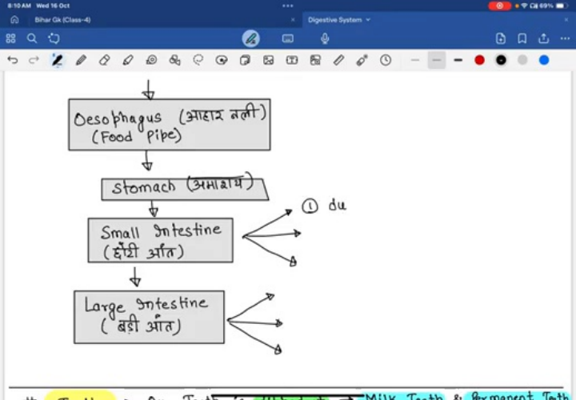

In [9]:
# @title 🛠️ Ultimate PDF Editor (Fixed & Robust)
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import shutil

# 1. --- Install Tools (if missing) ---
try:
    from pdf2image import convert_from_path
except ImportError:
    print("⚙️ Installing PDF tools...")
    !apt-get install -y poppler-utils > /dev/null
    !pip install -q pdf2image
    from pdf2image import convert_from_path
from google.colab import files

def create_pdf_editor():
    print("\n📂 Please upload the PDF you want to edit:")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded. Please rerun the cell.")
        return

    pdf_filename = list(uploaded.keys())[0]
    print("⏳ Processing pages... please wait.")

    # Load images
    try:
        original_images = convert_from_path(pdf_filename, dpi=100)
    except Exception as e:
        print(f"❌ Error reading PDF: {e}")
        return

    # --- Data State ---
    # We wrap state in a dictionary so inner functions can modify it easily
    state = {
        'data': [{'img': img, 'crop': [0, 0, 0, 0], 'keep': True} for img in original_images],
        'index': 0
    }

    # --- UI Widgets ---
    main_display = widgets.Output(layout={'border': '1px solid #444', 'height': '500px', 'width': '100%', 'display': 'flex', 'justify_content': 'center'})

    # Navigation
    btn_prev = widgets.Button(description="◀ Prev", layout=widgets.Layout(width='100px'))
    btn_next = widgets.Button(description="Next ▶", layout=widgets.Layout(width='100px'))
    lbl_page = widgets.Label(value=f"Page 1 of {len(state['data'])}")

    # Actions
    btn_move_up = widgets.Button(description="⬆ Move Up", button_style='info', layout=widgets.Layout(width='95%'))
    btn_move_down = widgets.Button(description="⬇ Move Down", button_style='info', layout=widgets.Layout(width='95%'))
    btn_toggle = widgets.Button(description="Status: KEEP ✅", button_style='success', layout=widgets.Layout(width='95%'))

    # Sliders
    slider_top = widgets.IntSlider(description='Top', min=0, max=100, value=0)
    slider_btm = widgets.IntSlider(description='Bottom', min=0, max=100, value=0)
    slider_left = widgets.IntSlider(description='Left', min=0, max=100, value=0)
    slider_right = widgets.IntSlider(description='Right', min=0, max=100, value=0)

    # Save
    btn_save = widgets.Button(description="💾 SAVE & DOWNLOAD PDF", button_style='primary', layout=widgets.Layout(width='100%', height='50px'))
    output_log = widgets.Output()

    # --- Logic ---
    def get_cropped_img(idx):
        entry = state['data'][idx]
        img = entry['img']
        w, h = img.size
        top, btm, left, right = entry['crop']

        # Calculate Box
        box = (left, top, w - right, h - btm)
        if box[2] <= box[0] or box[3] <= box[1]: return img # Invalid crop protection
        return img.crop(box)

    def refresh_view():
        idx = state['index']
        total = len(state['data'])
        if idx >= total: return

        entry = state['data'][idx]
        w, h = entry['img'].size

        # Update Sliders (without triggering events)
        slider_top.unobserve(on_slider_change, names='value')
        slider_btm.unobserve(on_slider_change, names='value')
        slider_left.unobserve(on_slider_change, names='value')
        slider_right.unobserve(on_slider_change, names='value')

        slider_top.max, slider_btm.max = h//2, h//2
        slider_left.max, slider_right.max = w//2, w//2

        slider_top.value = entry['crop'][0]
        slider_btm.value = entry['crop'][1]
        slider_left.value = entry['crop'][2]
        slider_right.value = entry['crop'][3]

        slider_top.observe(on_slider_change, names='value')
        slider_btm.observe(on_slider_change, names='value')
        slider_left.observe(on_slider_change, names='value')
        slider_right.observe(on_slider_change, names='value')

        # Update Buttons
        lbl_page.value = f"Page {idx + 1} of {total}"
        if entry['keep']:
            btn_toggle.description = "Status: KEEP ✅"
            btn_toggle.button_style = 'success'
            main_display.layout.border = '4px solid #28a745' # Green border
        else:
            btn_toggle.description = "Status: DELETE ❌"
            btn_toggle.button_style = 'danger'
            main_display.layout.border = '4px solid #dc3545' # Red border

        # Render Image
        preview = get_cropped_img(idx)
        with main_display:
            clear_output(wait=True)
            # Smart Resize for Display
            disp_h = 400
            ratio = disp_h / preview.height
            disp_w = int(preview.width * ratio)
            display(preview.resize((disp_w, disp_h)))

    def on_slider_change(change):
        idx = state['index']
        state['data'][idx]['crop'] = [slider_top.value, slider_btm.value, slider_left.value, slider_right.value]
        refresh_view()

    def change_page(step):
        new_idx = state['index'] + step
        if 0 <= new_idx < len(state['data']):
            state['index'] = new_idx
            refresh_view()

    def move_page(direction):
        idx = state['index']
        new_pos = idx + direction
        if 0 <= new_pos < len(state['data']):
            # Swap in list
            state['data'][idx], state['data'][new_pos] = state['data'][new_pos], state['data'][idx]
            state['index'] = new_pos
            refresh_view()

    def toggle_keep(b):
        idx = state['index']
        state['data'][idx]['keep'] = not state['data'][idx]['keep']
        refresh_view()

    def save_pdf(b):
        with output_log:
            clear_output()
            print("⏳ Generating Final PDF... (Applying crops)")
            final_images = []

            for entry in state['data']:
                if entry['keep']:
                    # Re-apply crop logic to ensure high quality
                    img = entry['img']
                    w, h = img.size
                    t, b_val, l, r = entry['crop']
                    box = (l, t, w - r, h - b_val)
                    if box[2] > box[0] and box[3] > box[1]:
                        final_images.append(img.crop(box))
                    else:
                        final_images.append(img)

            if not final_images:
                print("❌ No pages selected!")
                return

            out_name = f"EDITED_{pdf_filename}"
            final_images[0].save(out_name, save_all=True, append_images=final_images[1:])
            print(f"✅ DONE! Saved {len(final_images)} pages.")
            files.download(out_name)

    # --- Events ---
    btn_prev.on_click(lambda b: change_page(-1))
    btn_next.on_click(lambda b: change_page(1))
    btn_move_up.on_click(lambda b: move_page(-1))
    btn_move_down.on_click(lambda b: move_page(1))
    btn_toggle.on_click(toggle_keep)
    btn_save.on_click(save_pdf)

    slider_top.observe(on_slider_change, names='value')
    slider_btm.observe(on_slider_change, names='value')
    slider_left.observe(on_slider_change, names='value')
    slider_right.observe(on_slider_change, names='value')

    # --- Layout ---
    nav_bar = widgets.HBox([btn_prev, lbl_page, btn_next], layout=widgets.Layout(justify_content='center', margin='0 0 10px 0'))

    controls = widgets.VBox([
        widgets.HTML("<b>✂️ CROP</b>"), slider_top, slider_btm, slider_left, slider_right,
        widgets.HTML("<hr><b>📂 ORGANIZE</b>"), btn_toggle, widgets.HTML("<br>"), btn_move_up, btn_move_down
    ], layout=widgets.Layout(width='300px', padding='10px', border='1px solid #ccc'))

    ui = widgets.HBox([main_display, controls])

    display(nav_bar, ui, widgets.HTML("<hr>"), btn_save, output_log)
    refresh_view()

# Start
create_pdf_editor()

# 🚀 The "Playlist-Safe" Master Code

In [ ]:
# @title 🎓 Playlist-Safe YouTube Note-Maker
import os, shutil, cv2, yt_dlp, numpy as np, re
from fpdf import FPDF
from tqdm.notebook import tqdm
from PIL import Image

# --- Tuning ---
CHECK_EVERY_X_SECONDS = 15
SIMILARITY_THRESHOLD = 0.92
BLANK_THRESHOLD = 5.0
DOWNLOAD_RES = "480"

PDF_FOLDER = "Final_PDF_Notes"
RESOURCE_FOLDER = "Captured_Resources"

def setup_environment():
    if not os.path.exists(PDF_FOLDER): os.makedirs(PDF_FOLDER)
    if not os.path.exists(RESOURCE_FOLDER): os.makedirs(RESOURCE_FOLDER)

def clean_filename(title, index=None):
    clean = re.sub(r'[^\w\s-]', '', title).strip()
    clean = clean[:50] if clean else "Study_Notes"
    if index is not None:
        return f"{index:02d}_{clean}"
    return clean

def is_blank(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < BLANK_THRESHOLD

def get_similarity(img1, img2):
    h1 = cv2.calcHist([cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)], [0, 1], None, [50, 60], [0, 180, 0, 256])
    h2 = cv2.calcHist([cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)], [0, 1], None, [50, 60], [0, 180, 0, 256])
    cv2.normalize(h1, h1, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(h2, h2, 0, 1, cv2.NORM_MINMAX)
    return cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL)

def process_video(url, video_index=None):
    setup_environment()

    # Download
    print(f"\n🌐 Processing Video {video_index if video_index else ''}...")
    ydl_opts = {
        'format': f'bestvideo[height<={DOWNLOAD_RES}][ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': f'{RESOURCE_FOLDER}/temp_video.mp4',
        'overwrites': True, 'quiet': True, 'no_warnings': True
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        video_title = clean_filename(info.get('title', 'Notes'), video_index)

    cap = cv2.VideoCapture(f'{RESOURCE_FOLDER}/temp_video.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    last_img, saved_count = None, 0
    pbar = tqdm(total=total_frames, desc=f"Scanning {video_title[:20]}...")

    curr_frame = 0
    while curr_frame < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        ret, frame = cap.read()
        if not ret: break

        if not is_blank(frame):
            if last_img is None or get_similarity(frame, last_img) < SIMILARITY_THRESHOLD:
                cv2.imwrite(f"{RESOURCE_FOLDER}/s_{saved_count:03d}.jpg", frame)
                last_img = frame.copy()
                saved_count += 1

        curr_frame += int(fps * CHECK_EVERY_X_SECONDS)
        pbar.update(int(fps * CHECK_EVERY_X_SECONDS))

    cap.release()
    pbar.close()

    # Save PDF
    if saved_count > 0:
        imgs = sorted([f for f in os.listdir(RESOURCE_FOLDER) if f.startswith("s_")])
        with Image.open(f"{RESOURCE_FOLDER}/{imgs[0]}") as i: w, h = i.size
        pdf = FPDF(unit="pt", format=[w, h])
        for name in imgs:
            pdf.add_page()
            pdf.image(os.path.join(RESOURCE_FOLDER, name), 0, 0, w, h)

        out_path = os.path.join(PDF_FOLDER, f"{video_title}.pdf")
        pdf.output(out_path, "F")
        print(f"✅ PDF Saved: {out_path}")

    # CLEANUP ONLY IMAGES AND VIDEO (Keep PDF_FOLDER safe)
    if os.path.exists(f'{RESOURCE_FOLDER}/temp_video.mp4'): os.remove(f'{RESOURCE_FOLDER}/temp_video.mp4')
    for f in os.listdir(RESOURCE_FOLDER):
        if f.startswith("s_") and f.endswith(".jpg"):
            os.remove(os.path.join(RESOURCE_FOLDER, f))

# --- Main Entry ---
input_url = input("Paste YouTube Video or Playlist Link: ").strip()

if "playlist" in input_url:
    print("📋 Playlist detected. Extracting video list...")
    with yt_dlp.YoutubeDL({'extract_flat': True, 'quiet': True}) as ydl:
        playlist_info = ydl.extract_info(input_url, download=False)
        video_entries = playlist_info.get('entries', [])

        for i, entry in enumerate(video_entries, 1):
            process_video(entry['url'], video_index=i)
else:
    process_video(input_url)

print("\n🎉 ALL DONE! Check the 'Final_PDF_Notes' folder.")